<a href="https://colab.research.google.com/github/tomonari-masada/courses/blob/master/Hiroshima_Univ_Topic_Modeling_HandsOn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第1回AI・データイノベーションセミナー 2021年3月11日（木曜日）

## トピックモデリングの実践

* トピックモデリングを、NMF(nonnegative matrix factorization)とLDA(latent Dirichlet allocation)とで実践してみる。
* いずれもscikit-learnの実装を使う。
* 各トピックの上位単語はワードクラウドで可視化する。

* 参考資料
 * https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html



---



## 01 データセットの準備
* NeurIPSで発表された1,740本の論文の本文を使う。

### データをダウンロードしリスト化する関数を定義

* PATHで指定した場所に文書ファイルが配置される。

In [1]:
import io
import os.path
import re
import tarfile
import smart_open


PATH = './' # ここは適当に設定


def extract_documents(url='https://cs.nyu.edu/~roweis/data/nips12raw_str602.tgz'):

  fname = os.path.join(PATH, url.split('/')[-1])

  if not os.path.isfile(fname):
    with smart_open.open(url, "rb") as fin:
      with smart_open.open(fname, 'wb') as fout:
        while True:
          buf = fin.read(io.DEFAULT_BUFFER_SIZE)
          if not buf:
            break
          fout.write(buf)

  with tarfile.open(fname, mode='r:gz') as tar:
  # Ignore directory entries, as well as files like README, etc.
    files = [
             m for m in tar.getmembers()
             if m.isfile() and re.search(r'nipstxt/nips\d+/\d+\.txt', m.name)
             ]
    for member in sorted(files, key=lambda x: x.name):
      member_bytes = tar.extractfile(member).read()
      yield member_bytes.decode('utf-8', errors='replace')

* 実際にデータを取得しリスト化する

In [2]:
docs = list(extract_documents())

* 文書数、具体的な文書の内容などを確認

In [3]:
print(len(docs))

1740


In [4]:
print(docs[0][:1000])

1 
CONNECTIVITY VERSUS ENTROPY 
Yaser S. Abu-Mostafa 
California Institute of Technology 
Pasadena, CA 91125 
ABSTRACT 
How does the connectivity of a neural network (number of synapses per 
neuron) relate to the complexity of the problems it can handle (measured by 
the entropy)? Switching theory would suggest no relation at all, since all Boolean 
functions can be implemented using a circuit with very low connectivity (e.g., 
using two-input NAND gates). However, for a network that learns a problem 
from examples using a local learning rule, we prove that the entropy of the 
problem becomes a lower bound for the connectivity of the network. 
INTRODUCTION 
The most distinguishing feature of neural networks is their ability to spon- 
taneously learn the desired function from 'training' samples, i.e., their ability 
to program themselves. Clearly, a given neural network cannot just learn any 
function, there must be some restrictions on which networks can learn which 
functions. One obv

### spaCyを使ってtokenizeする
* spaCyについては https://spacy.io/ を参照

* 前処理の高速化のためtaggerなどは無効にしておく

In [5]:
import spacy

nlp = spacy.load('en', disable=["tagger", "parser", "ner"])

* テキストを小文字にしてからtokenizeする関数の定義

In [6]:
def spacy_lemmatize_text(nlp, text):
  text = nlp(text.lower())
  doc = [word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text]
  return [word for word in doc if len(word) > 1] # 長さ1の単語は削除

* tokenizationの実行

In [7]:
from tqdm import tqdm

new_docs = list()
for doc in tqdm(docs):
  new_docs.append(spacy_lemmatize_text(nlp, doc))

100%|██████████| 1740/1740 [01:03<00:00, 27.23it/s]


* tokenizationの結果を確認

In [8]:
print(new_docs[0])

['connectivity', 'versus', 'entropy', 'yaser', 's.', 'abu', 'mostafa', 'california', 'institute', 'of', 'technology', 'pasadena', 'ca', '91125', 'abstract', 'how', 'doe', 'the', 'connectivity', 'of', 'neural', 'network', 'numb', 'of', 'synapsis', 'per', 'neuron', 'relate', 'to', 'the', 'complexity', 'of', 'the', 'problem', 'it', 'can', 'handle', 'measure', 'by', 'the', 'entropy', 'switch', 'theory', 'would', 'suggest', 'no', 'relation', 'at', 'all', 'since', 'all', 'boolean', 'function', 'can', 'be', 'implement', 'use', 'circuit', 'with', 'very', 'low', 'connectivity', 'e.g.', 'use', 'two', 'input', 'nand', 'gate', 'however', 'for', 'network', 'that', 'learn', 'problem', 'from', 'example', 'use', 'local', 'learn', 'rule', 'we', 'prove', 'that', 'the', 'entropy', 'of', 'the', 'problem', 'become', 'low', 'bind', 'for', 'the', 'connectivity', 'of', 'the', 'network', 'introduction', 'the', 'much', 'distinguish', 'feature', 'of', 'neural', 'network', 'be', 'their', 'ability', 'to', 'spon-',

* 各文書を長い文字列で表しなおす（後でCountVectorizerを使うため）

In [9]:
corpus = [' '.join(doc) for doc in new_docs]

In [10]:
corpus[0]

'connectivity versus entropy yaser s. abu mostafa california institute of technology pasadena ca 91125 abstract how doe the connectivity of neural network numb of synapsis per neuron relate to the complexity of the problem it can handle measure by the entropy switch theory would suggest no relation at all since all boolean function can be implement use circuit with very low connectivity e.g. use two input nand gate however for network that learn problem from example use local learn rule we prove that the entropy of the problem become low bind for the connectivity of the network introduction the much distinguish feature of neural network be their ability to spon- taneously learn the desire function from train sample i.e. their ability to program themselves clearly give neural network can not just learn any function there must be some restriction on which network can learn which function one obvious restriction which be independent of the learn aspect be that the network must be big enou

## 02 データ行列の作成
* NMFの場合、TF-IDFで単語の重みを求めて各文書をベクトル化する。
* LDAの場合、単に単語の出現頻度を重みとして各文書をベクトル化する。

### sklearnのCountVectorizerで疎行列化する

* 全文書の半分より多い文書に現れる単語は、高頻度語とみなして削除する。
* 10件未満の文書にしか現れない単語は、低頻度語とみなして削除する。

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_df=0.5, min_df=10, stop_words='english')
X = vectorizer.fit_transform(corpus)

In [12]:
print(X[0])

  (0, 2822)	12
  (0, 9123)	1
  (0, 3692)	9
  (0, 9437)	1
  (0, 1519)	4
  (0, 5971)	4
  (0, 2370)	1
  (0, 4936)	2
  (0, 8535)	1
  (0, 6598)	1
  (0, 2356)	1
  (0, 1360)	1
  (0, 8444)	3
  (0, 6165)	27
  (0, 7376)	1
  (0, 2742)	3
  (0, 4434)	1
  (0, 8424)	3
  (0, 8349)	1
  (0, 7377)	1
  (0, 2249)	2
  (0, 4757)	1
  (0, 2567)	4
  (0, 4222)	2
  (0, 7631)	2
  :	:
  (0, 6979)	1
  (0, 2459)	1
  (0, 252)	1
  (0, 3187)	1
  (0, 3539)	1
  (0, 6889)	2
  (0, 354)	2
  (0, 4036)	1
  (0, 2006)	1
  (0, 5738)	1
  (0, 4525)	1
  (0, 345)	1
  (0, 3899)	1
  (0, 4679)	1
  (0, 8763)	1
  (0, 9192)	1
  (0, 592)	1
  (0, 851)	1
  (0, 864)	1
  (0, 5204)	1
  (0, 8464)	1
  (0, 1758)	1
  (0, 5749)	1
  (0, 1604)	1
  (0, 9290)	1


In [ ]:
print(vectorizer.get_feature_names())

In [14]:
print(len(vectorizer.get_feature_names()))

9523


* 文書数と語彙サイズを変数にセット

In [15]:
X.shape

(1740, 9523)

In [16]:
n_samples, n_features = X.shape

### TF-IDFで各文書における単語の重みを計算する

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer()
Xtfidf = tfidf.fit_transform(X)

In [18]:
print(Xtfidf[0])

  (0, 9505)	0.04415177177651438
  (0, 9477)	0.026119306096916872
  (0, 9437)	0.03081469250861011
  (0, 9411)	0.019315048232435583
  (0, 9407)	0.01607244572674325
  (0, 9401)	0.013127776498956592
  (0, 9385)	0.017602563514355435
  (0, 9368)	0.023372453241481607
  (0, 9365)	0.02512862947613459
  (0, 9352)	0.012618561839450844
  (0, 9290)	0.017857636971958038
  (0, 9192)	0.0119043669146374
  (0, 9182)	0.12915359012047617
  (0, 9170)	0.012109792594674972
  (0, 9160)	0.0316304193216004
  (0, 9149)	0.009898435866014686
  (0, 9125)	0.02285549140266676
  (0, 9123)	0.015019030404060009
  (0, 9121)	0.01031353987404144
  (0, 9090)	0.030449599501948282
  (0, 9083)	0.012630712819979658
  (0, 9080)	0.01171684435145176
  (0, 9060)	0.02367121821565705
  (0, 9057)	0.021086977604899946
  (0, 9053)	0.11264871220575023
  :	:
  (0, 1674)	0.025530727876224266
  (0, 1648)	0.02165789898673774
  (0, 1604)	0.018023536128916356
  (0, 1558)	0.00988393791257569
  (0, 1545)	0.018592324686697553
  (0, 1539)	0.009804

In [19]:
Xtfidf.shape

(1740, 9523)

* 抽出するトピックの個数は、今回は20個とする。

In [20]:
n_components = 20

## 03 NMFでトピック抽出
* まず、TF-IDFのデータ行列を使って　NMFによってトピック抽出を試みる。
 * NMFのパラメータ群は下記サンプルコードを参考にした。
 * https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

### NMFとLDAのインポート

In [21]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

### NMFによるトピック抽出の実行

In [22]:
from time import time

print((f"Fitting the NMF model (generalized Kullback-Leibler "
  f"divergence) with tf-idf features, n_samples={n_samples} "
  f"and n_features={n_features}"))
t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1, l1_ratio=.5,
          verbose=1)
nmf.fit(Xtfidf)
print(f"done in {time() - t0:0.3f}s.")

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=1740 and n_features=9523
Epoch 10 reached after 4.294 seconds, error: 302.043618
Epoch 20 reached after 8.377 seconds, error: 301.379006
Epoch 30 reached after 12.406 seconds, error: 301.223353
Epoch 40 reached after 16.478 seconds, error: 301.157200
Epoch 50 reached after 20.518 seconds, error: 301.118746
Epoch 60 reached after 24.600 seconds, error: 301.094039
done in 25.515s.


* NMFにおける各コンポーネントは、それぞれのトピックにおける単語の重要度を表すベクトルとして表現されている。

In [23]:
nmf.components_

array([[1.53183148e-01, 7.89228443e-02, 9.10985346e-04, ...,
        0.00000000e+00, 3.47116816e-03, 5.24823746e-05],
       [2.68610479e-02, 0.00000000e+00, 8.69703208e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.67866991e-03, 0.00000000e+00, 5.09770698e-09],
       ...,
       [0.00000000e+00, 4.14924307e-02, 2.88973893e-03, ...,
        0.00000000e+00, 8.48063177e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 4.23742316e-03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 2.65848707e-03]])

### トピックの重要語を取り出す関数の定義

In [24]:
def get_top_words(model, feature_names, n_top_words=30):
  top_features = list()
  weights = list()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
    top_features.append([feature_names[i] for i in top_features_ind])
    weights.append(topic[top_features_ind])
  return top_features, weights

### NMFの各コンポーネントから重要語を取り出す

In [25]:
top_words, weights = get_top_words(nmf, vectorizer.get_feature_names())

In [26]:
print(top_words[0])

['hide', 'noise', 'activation', 'net', 'solution', 'sample', 'simulation', 'propagation', 'generalization', 'rule', '1992', 'gradient', '1993', '1990', '1991', 'scale', 'initial', 'architecture', 'curve', 'approximation', 'dynamic', 'correlation', 'lead', 'optimal', 'denote', '13', 'pp', 'machine', '100', 'nonlinear']


In [27]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

In [28]:
topic_words[0]

{'100': 0.18301164923664373,
 '13': 0.19109265618516733,
 '1990': 0.22088959185481016,
 '1991': 0.2166497725916808,
 '1992': 0.2325025482044163,
 '1993': 0.22253387215091114,
 'activation': 0.31165981941494325,
 'approximation': 0.2033783567320828,
 'architecture': 0.21003928914141806,
 'correlation': 0.19501601023468398,
 'curve': 0.20612992151114087,
 'denote': 0.19169607886752338,
 'dynamic': 0.19831915647066461,
 'generalization': 0.233980034477949,
 'gradient': 0.2252151738132561,
 'hide': 0.5525785485159613,
 'initial': 0.21229831798681478,
 'lead': 0.19493580282829392,
 'machine': 0.18322847746210608,
 'net': 0.28929494794057287,
 'noise': 0.3151275823540324,
 'nonlinear': 0.1821798596151383,
 'optimal': 0.19273848234261737,
 'pp': 0.1889911795870892,
 'propagation': 0.2420674286178413,
 'rule': 0.23275478669679533,
 'sample': 0.24952250882111293,
 'scale': 0.21253422313040413,
 'simulation': 0.24851457364277926,
 'solution': 0.2545061261575209}

### 重要語をワードクラウドで可視化

In [29]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS

* ワードクラウドから除去するストップワードを確認する。

In [30]:
print(STOPWORDS)

{'not', 'com', 'a', 'else', 'but', 'nor', 'he', 'was', "it's", 'also', 'who', "isn't", 'would', "shouldn't", 'again', "can't", 'after', "we're", "hadn't", "aren't", 'you', "you're", 'same', 'and', 'any', 'k', 'have', 'www', "where's", 'above', 'she', 'which', 'your', 'ought', "they'd", 'cannot', 'to', 'in', 'were', "she's", 'otherwise', 'all', 'against', 'up', "how's", 'where', 'had', "let's", "she'd", 'them', 'very', 'be', 'for', 'being', 'do', 'is', 'can', 'yourselves', "here's", "shan't", "when's", 'there', 'yourself', 'at', 'off', 'on', 'too', "what's", 'however', "weren't", 'him', "i'm", 'get', "we'll", 'most', 'ever', "you've", 'out', 'few', 'my', 'they', "they're", 'should', 'does', 'doing', 'theirs', 'into', 'of', 'myself', 'own', 'it', "we'd", 'below', 'like', 'no', "i'll", 'http', 'an', 'further', 'until', 'their', 'under', 'itself', 'during', 'when', "don't", "hasn't", "who's", "why's", 'hers', 'that', 'because', 'over', 'just', 'than', 'shall', 'the', 'himself', "he's", "di

* ワードクラウドを描画

In [31]:
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

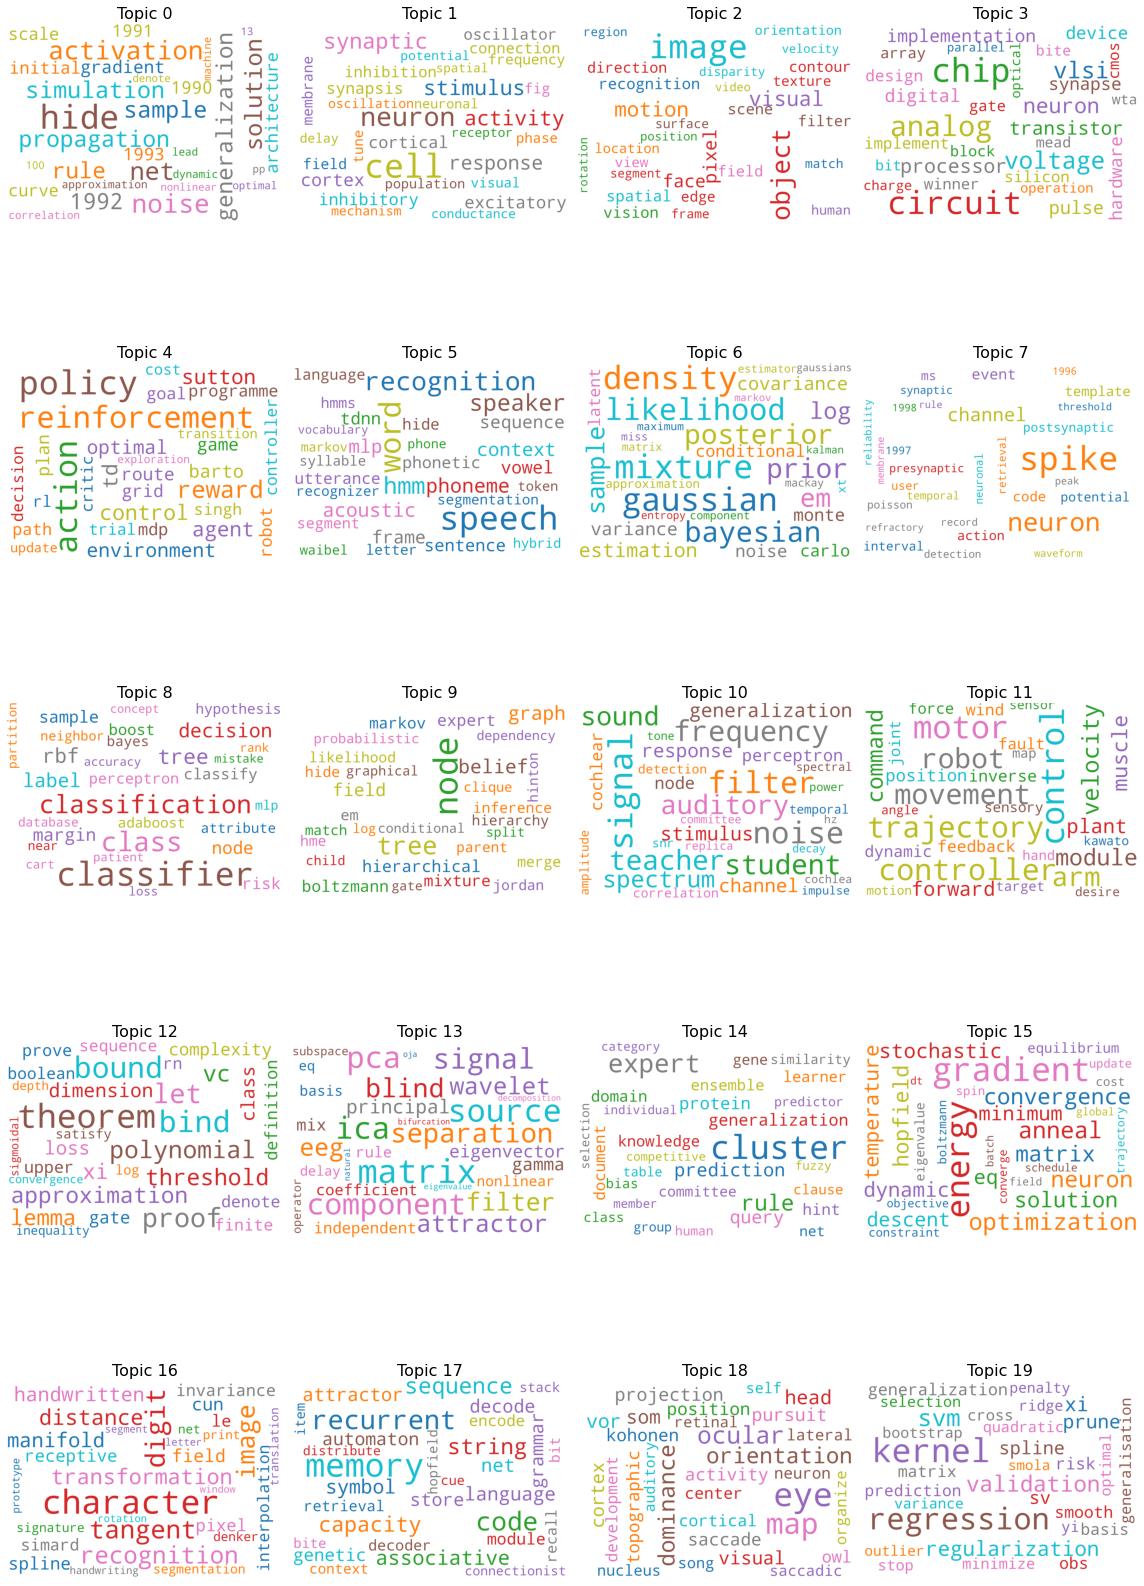

In [32]:
fig, axes = plt.subplots(5, 4, figsize=(16, 25), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=300)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

## 04 scikit-learnのLDAでトピック抽出

### LDAによるトピック抽出の実行

In [33]:
lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=20,
                                topic_word_prior=0.01,
                                learning_method='online',
                                learning_offset=50,
                                batch_size=200,
                                mean_change_tol=1e-4,
                                random_state=1,
                                evaluate_every=1,
                                verbose=1)

In [34]:
print((f"Fitting LDA models with tf features, "
  f"n_samples={n_samples} and n_features={n_features}"))
t0 = time()
lda.fit(X)
print(f"done in {time() - t0:0.3f}s.")

Fitting LDA models with tf features, n_samples=1740 and n_features=9523
iteration: 1 of max_iter: 20, perplexity: 3757.5115
iteration: 2 of max_iter: 20, perplexity: 3453.8655
iteration: 3 of max_iter: 20, perplexity: 3276.5438
iteration: 4 of max_iter: 20, perplexity: 3142.0168
iteration: 5 of max_iter: 20, perplexity: 3030.8090
iteration: 6 of max_iter: 20, perplexity: 2935.3267
iteration: 7 of max_iter: 20, perplexity: 2852.1615
iteration: 8 of max_iter: 20, perplexity: 2782.6435
iteration: 9 of max_iter: 20, perplexity: 2725.5558
iteration: 10 of max_iter: 20, perplexity: 2678.4953
iteration: 11 of max_iter: 20, perplexity: 2639.9885
iteration: 12 of max_iter: 20, perplexity: 2608.2159
iteration: 13 of max_iter: 20, perplexity: 2582.4180
iteration: 14 of max_iter: 20, perplexity: 2561.6611
iteration: 15 of max_iter: 20, perplexity: 2544.7529
iteration: 16 of max_iter: 20, perplexity: 2531.1231
iteration: 17 of max_iter: 20, perplexity: 2520.0326
iteration: 18 of max_iter: 20, perpl

### LDAの各トピックから高確率語を取り出す

In [35]:
top_words, weights = get_top_words(lda, vectorizer.get_feature_names())

In [36]:
print(top_words[0])

['cell', 'response', 'neuron', 'visual', 'stimulus', 'spike', 'activity', 'motion', 'field', 'direction', 'frequency', 'signal', 'spatial', 'temporal', 'synaptic', 'cortex', 'fig', 'tune', 'cortical', 'orientation', 'connection', 'filter', 'noise', 'image', 'channel', 'object', 'mechanism', 'phase', 'correlation', 'ii']


In [37]:
topic_words = [dict(zip(top_words[i], weights[i])) for i in range(n_components)]

### 高確率語をワードクラウドで可視化

In [38]:
cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=100,
                  colormap='tab10'
                  )

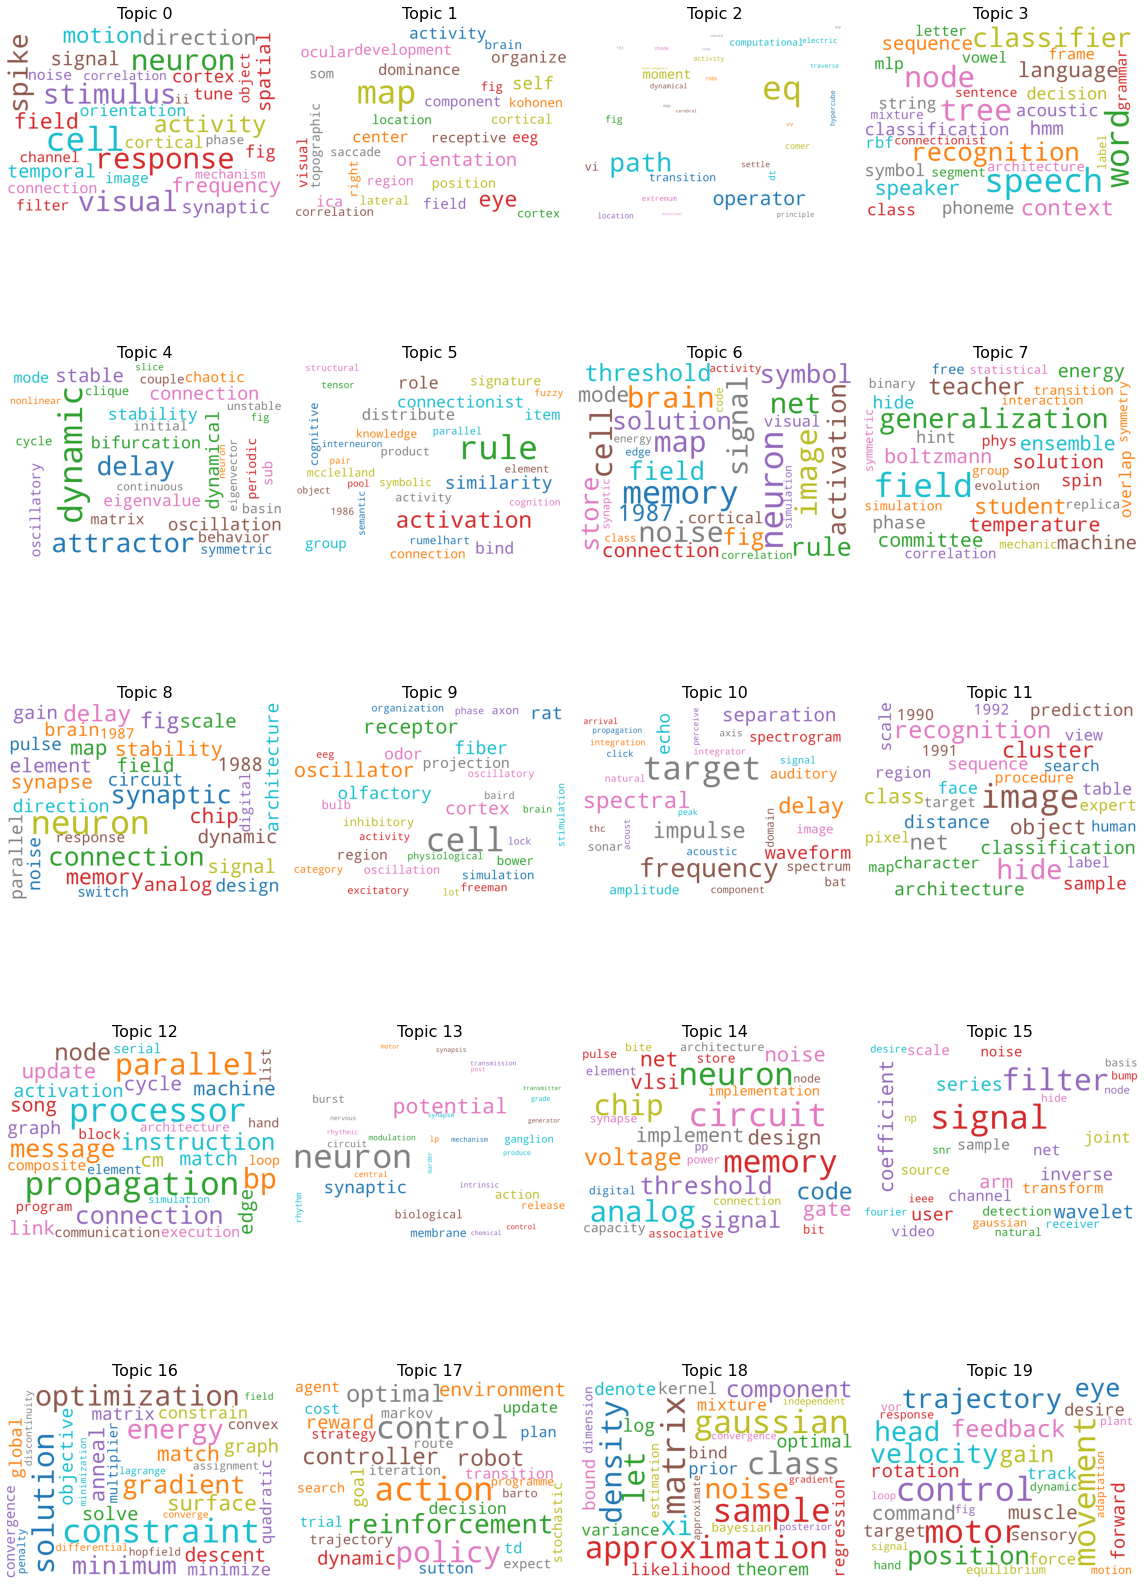

In [39]:
fig, axes = plt.subplots(5, 4, figsize=(16, 25), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
  fig.add_subplot(ax)
  cloud.generate_from_frequencies(topic_words[i], max_font_size=300)
  plt.gca().imshow(cloud)
  plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
  plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

### pyLDAvisという可視化ツールでトピックを可視化
* https://pyldavis.readthedocs.io/en/latest/

In [ ]:
!pip install pyLDAvis

In [41]:
import pyLDAvis
import pyLDAvis.sklearn

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [42]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, X, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
11     -10.878068   10.538728       1        1  25.835158
18     -60.884026  -75.591820       2        1  21.853766
0       -2.336119  -53.289074       3        1  14.917894
14     -61.385319  -12.914634       4        1   9.634493
17     -28.737743  126.296997       5        1   7.203002
3        1.066606 -123.552811       6        1   5.631652
1       45.140720   -7.947869       7        1   2.955029
19    -140.795975  -98.530548       8        1   1.887306
5       61.531681  -83.240562       9        1   1.661340
16     -72.563057 -140.396881      10        1   1.634541
7       15.984491   63.578186      11        1   1.466705
15    -160.851624   68.945145      12        1   1.248452
12      85.961830   51.922935      13        1   1.093134
4      -99.020836  109.936348      14        1   0.969593
9     -176.764130   -8.681684      15        1   0.735872
13    -117.189880  -37.420200      16        1   0.684374
10     108.829918  -22.946203      17        1   0.377475
2       47.588097  121.934814      18        1   0.200415
8     -106.467834   30.176889      19        1   0.004899
6      -50.613804   59.328842      20        1   0.004899, topic_info=            Term         Freq        Total Category  logprob  loglift
6165      neuron  9418.000000  9418.000000  Default  30.0000  30.0000
2461        cell  6278.000000  6278.000000  Default  29.0000  29.0000
7917      signal  5452.000000  5452.000000  Default  28.0000  28.0000
7631        rule  4724.000000  4724.000000  Default  27.0000  27.0000
8511      target  3110.000000  3110.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
3664      energy     0.015986  1881.528179  Topic20  -8.6009  -1.7520
7949  simulation     0.016083  2861.476303  Topic20  -8.5949  -2.1652
8445    synaptic     0.015921  2338.679138  Topic20  -8.6050  -1.9736
2589       class     0.016094  4986.511148  Topic20  -8.5942  -2.7199
2640        code     0.015891  2787.571319  Topic20  -8.6069  -2.1511

[1317 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
19        5  0.999050      01003
136       1  0.095262       1045
136       5  0.571573       1045
136       6  0.285786       1045
190       1  0.106338       1147
...     ...       ...        ...
9498      1  0.993242        zip
9501      1  0.223517  zisserman
9501     10  0.726431  zisserman
9512      3  0.437321  zornetzer
9512     15  0.524786  zornetzer

[5345 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 19, 1, 15, 18, 4, 2, 20, 6, 17, 8, 16, 13, 5, 10, 14, 11, 3, 9, 7])

## 05 gensimのLDAでトピック抽出

* gensimのLdaModelはデフォルトの設定だと正しく動かない
 * passesを20ぐらいにはしておくこと。
 * 下記Webページは使い方を間違っているので要注意（passesをデフォルト設定で使っている）
 http://www.ie110704.net/2018/12/29/wordcloud%E3%81%A8pyldavis%E3%81%AB%E3%82%88%E3%82%8Blda%E3%81%AE%E5%8F%AF%E8%A6%96%E5%8C%96%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6/
* gensimのperplexityはトークンあたりのELBOのnp.exp2()で求めている
 * 自然対数の底を使って求めたELBOをもとにして計算しているにもかかわらず。


In [43]:
from gensim import corpora

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [44]:
dictionary = corpora.Dictionary(new_docs)

In [45]:
print(dictionary)

Dictionary(154896 unique tokens: [',k', ',n', '--', "--'\x7f1", '-/v']...)


In [46]:
dictionary.filter_extremes(no_below=10, no_above=0.5)

In [47]:
len(dictionary)

10688

In [48]:
gs_corpus = [dictionary.doc2bow(doc) for doc in new_docs]

In [49]:
print(gs_corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 7), (4, 3), (5, 2), (6, 3), (7, 2), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 2), (17, 1), (18, 1), (19, 4), (20, 1), (21, 1), (22, 1), (23, 1), (24, 2), (25, 4), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 8), (40, 1), (41, 3), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 3), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 3), (59, 12), (60, 1), (61, 7), (62, 4), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 4), (73, 2), (74, 1), (75, 1), (76, 1), (77, 3), (78, 1), (79, 1), (80, 1), (81, 3), (82, 12), (83, 1), (84, 3), (85, 1), (86, 2), (87, 1), (88, 1), (89, 2), (90, 3), (91, 1), (92, 6), (93, 2), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 7), (100, 2), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 3

In [50]:
import logging
logging.basicConfig(filename='myapp.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [51]:
import warnings
warnings.filterwarnings("ignore")

In [52]:
from gensim.models.ldamodel import LdaModel

In [53]:
lda = LdaModel(corpus=gs_corpus, num_topics=n_components,
               passes=20)

In [54]:
import numpy as np

np.exp(- lda.log_perplexity(gs_corpus))

2567.6543280035244